<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# Musterlösung / Sample solution 
## 10th exercise: <font color="#C70039">Interpretable Machine Learning with Shapley Values for image classification</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   09.08.2023

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
This is one implementation example to demo XAI for image classification using the inbuild cifar-10 data set, that you have come across with in exercise 8 already.

## Imports
Import all necessary utilities.

In [1]:
import shap
import numpy as np
import tensorflow as tf
from   tensorflow import keras
import matplotlib.pyplot as plt
from   tensorflow.keras.models import Sequential
import ssl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020


## load build-in dataset
take the cifar-10 data set from exercise 8

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# reshape and normalize data
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

### Build a simple CNN, compile and fit the model.

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="test_for_shap")
# compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

Epoch 1/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.4620 - sparse_categorical_accuracy: 0.4751 - val_loss: 1.2422 - val_sparse_categorical_accuracy: 0.5616
Epoch 2/10
1563/1563 [==============================] - 18s 11ms/step - loss: 1.1200 - sparse_categorical_accuracy: 0.6058 - val_loss: 1.0844 - val_sparse_categorical_accuracy: 0.6132
Epoch 3/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.9530 - sparse_categorical_accuracy: 0.6645 - val_loss: 1.0348 - val_sparse_categorical_accuracy: 0.6422
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8249 - sparse_categorical_accuracy: 0.7106 - val_loss: 1.0128 - val_sparse_categorical_accuracy: 0.6480
Epoch 5/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.7085 - sparse_categorical_accuracy: 0.7515 - val_loss: 1.0418 - val_sparse_categorical_accuracy: 0.6530
Epoch 6/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.

### predict on the test set (one image for each class).

In [4]:
# class label list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# example image for each class
images_dict = dict()

for i, l in enumerate(y_train):
    if len(images_dict)==10:
        break
    if l not in images_dict.keys():
        images_dict[l] = x_train[i].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))
    
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict)==10:
        break
    if l not in x_test_dict.keys():
        x_test_dict[l] = x_test[i]
        
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 100ms/step


### Visualization
#### plot function
define a plot function for actual and predicted class.

In [5]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(1, 11, figsize=(16, 15))
    axes = axes.flatten()
  
    # plot
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("Base reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')
    
    # plot image
    for k,v in images.items():
        ax = axes[k+1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

#### XAI using SHAP
Now use the SHAP library to generate the Shapley values

In [6]:
# select background for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

# use DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

# compute the shapley values
shap_values = explainer.shap_values(x_test_each_class)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


#### plot the Shapley values

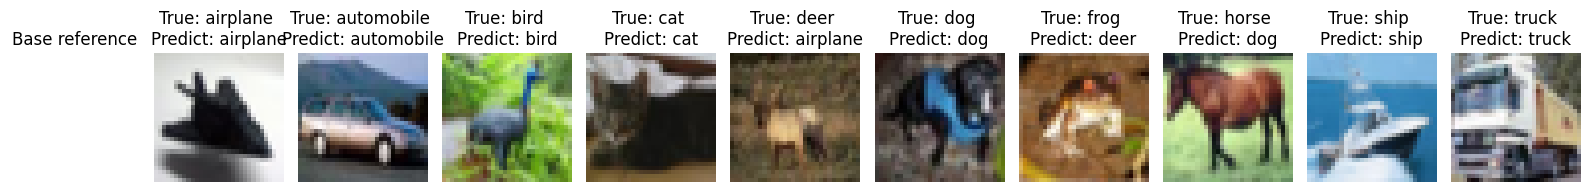

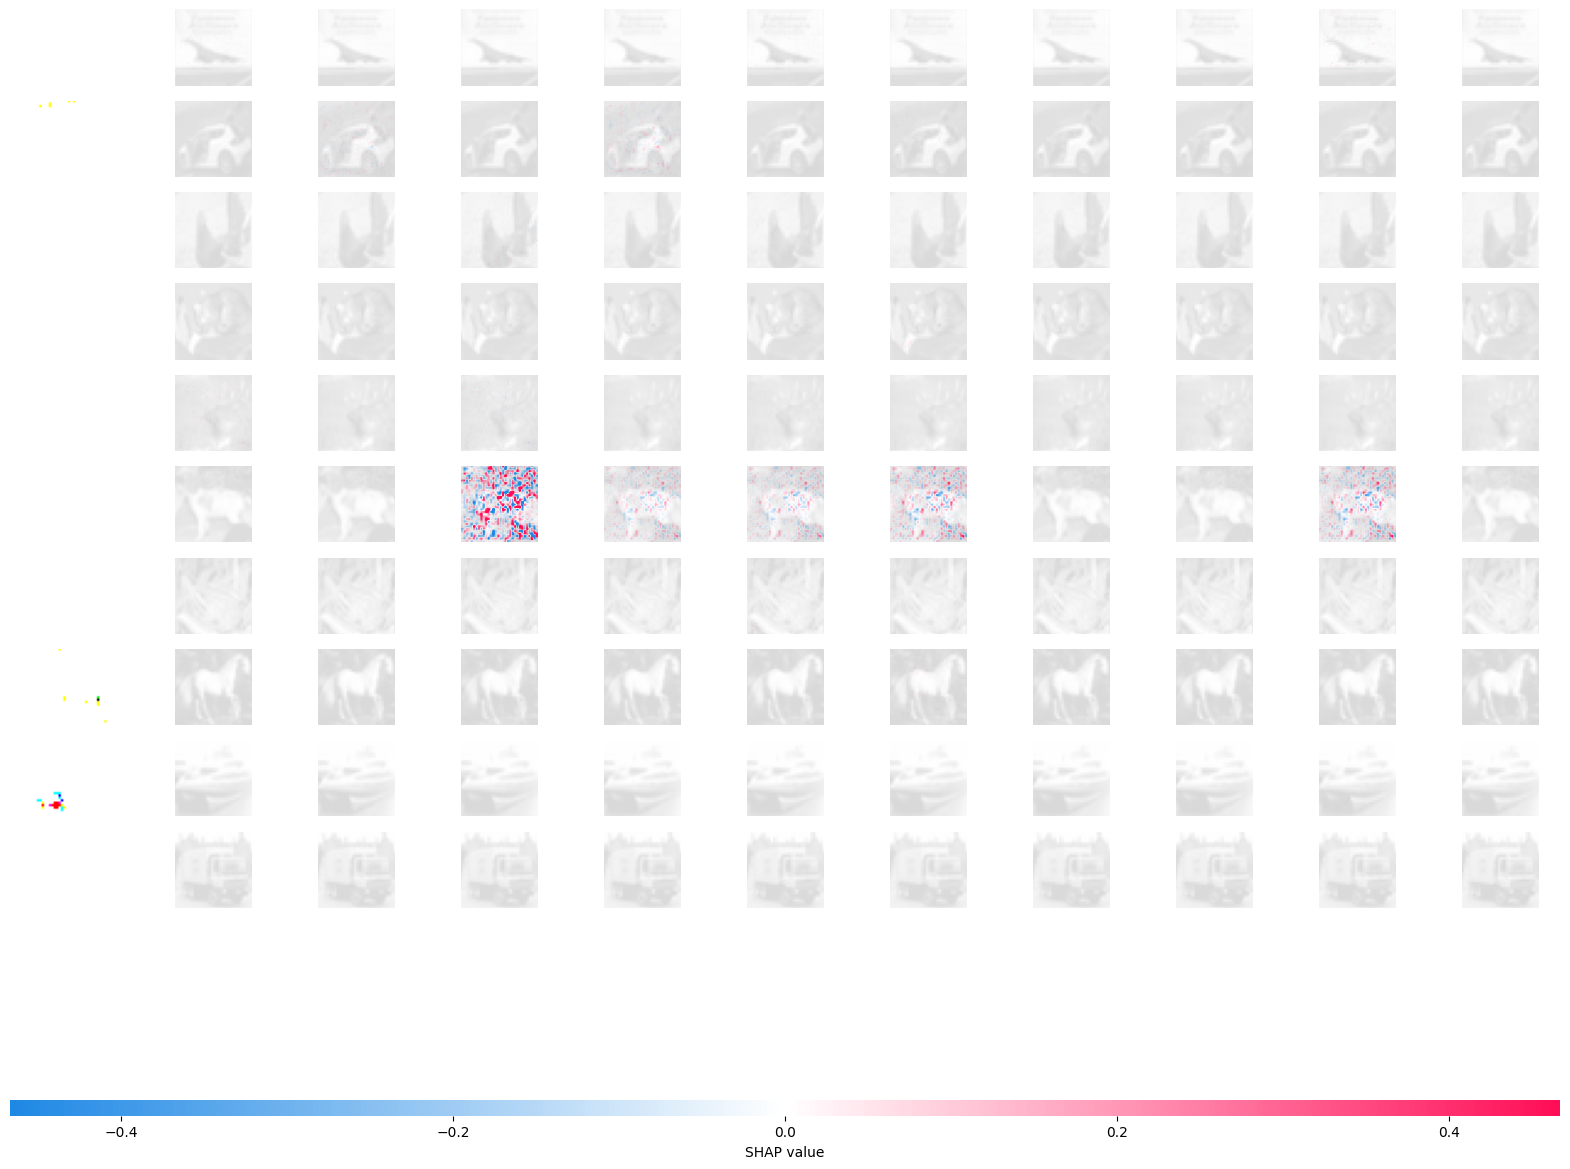

In [7]:
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class * 255)